In [109]:
pip install pymoo

Note: you may need to restart the kernel to use updated packages.


In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.visualization.scatter import Scatter
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from pymoo.indicators.hv import HV

# 1. Generating a Synthetic Classification Dataset

In [122]:
X, y = make_classification(n_samples=500, n_features=60, n_informative=30, n_redundant=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("First few rows of Features (X):")
print(X[:5])
print("\nFirst few Labels (y):")
print(y[:40])

First few rows of Features (X):
[[-2.25264472e-01 -2.35529083e+00  1.86610893e+00  4.84577193e-01
   1.04212831e+00 -1.56070988e+00 -7.85099564e+00  1.56537832e+00
  -8.25614502e+00  9.33342304e-01  5.07591097e-01 -2.29655878e-01
   8.39201921e+00 -1.29820718e+01 -1.90691401e+00  7.02153808e-01
   3.81696102e+00 -4.74181755e-01  9.61035689e-01 -6.25165788e-01
   2.61272879e+00 -4.30365963e-01  4.73007955e-01 -1.31289482e+01
  -1.80214502e+00  1.64829459e+00  5.74125527e+00 -2.79839076e-01
  -1.17613528e+00 -1.16984952e+01  3.61135006e+00 -1.24444711e+01
  -5.42115787e-01  3.07473062e+00  8.44003147e-01 -1.31942455e+01
   5.88197920e+00  9.30254623e-01  3.72735719e+00  1.60007437e+01
   1.35730624e+00 -2.93935796e+00  1.29219804e+00 -5.41966315e+00
   1.01254937e+01 -1.10996159e-01 -3.52964231e-01  2.86178958e+00
  -3.10373287e+00  1.19857367e+00  7.83119335e+00  2.15777858e+00
   1.29040436e+00  1.54140147e+00 -8.23197657e-01  1.81594523e+00
  -1.03213951e+01 -4.48177419e-01  1.8874233

In [123]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((350, 60), (150, 60), (350,), (150,))




# 2. Defining the Problem

In [140]:
class ClassificationProblemMultiObj(Problem):

    def __init__(self):
        super().__init__(n_var=60, n_obj=2, n_constr=0, xl=0, xu=1)  # 60 features, 2 objectives, binary decision variables

    def _evaluate(self, x, out, *args, **kwargs):
        error = []
        feature_count = []
        for weights in x:
            weights_numeric = weights.astype(int)
            weighted_features = X_train * weights_numeric
            selected_features = np.sum(weights_numeric)
            if selected_features == 0:
                accuracy.append(0)  # If no feature is selected, accuracy is 0
            else:
                model = KNeighborsClassifier(n_neighbors=5)
                model.fit(weighted_features, y_train)
                predictions = model.predict(X_test * weights_numeric)  # Apply the same weights to the test data
                acc = accuracy_score(y_test, predictions)
                err = 1-acc 
                error.append(err)
                feature_count.append(selected_features)
        out["F"] = np.column_stack([np.array(feature_count), np.array(error)])


In [141]:
problem = ClassificationProblemMultiObj()

In [142]:
print(problem)

# name: ClassificationProblemMultiObj
# n_var: 60
# n_obj: 2
# n_ieq_constr: 0
# n_eq_constr: 0



# 3. Setup the NSGA2 Algorithm

In [143]:
algorithm = NSGA2(pop_size=100,
                  sampling=BinaryRandomSampling(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

# 4. Defining the Termination Criteria 

In [144]:
termination = get_termination("n_gen", 100)

# 5. Optimizing the Problem

In [145]:
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
solutions = res.X

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      6 |             - |             -
     2 |      200 |      9 |  0.0869565217 |         ideal
     3 |      300 |     10 |  0.0588235294 |         ideal
     4 |      400 |     13 |  0.0370370370 |         ideal
     5 |      500 |     11 |  0.6875000000 |         nadir
     6 |      600 |     11 |  0.3157894737 |         ideal
     7 |      700 |     10 |  0.2083333333 |         ideal
     8 |      800 |     10 |  0.2941176471 |         nadir
     9 |      900 |      9 |  0.1111111111 |         ideal
    10 |     1000 |     12 |  0.0526315789 |         ideal
    11 |     1100 |     15 |  0.0333121503 |             f
    12 |     1200 |     10 |  0.0285714286 |         ideal
    13 |     1300 |     11 |  0.1304347826 |         ideal
    14 |     1400 |     12 |  0.0163081112 |             f
    15 |     1500 |     16 |  0.0434782609 |         ideal
    16 |     1600 |     17 |  0.0131532583 |            

the intial pareto front is plotted as: 


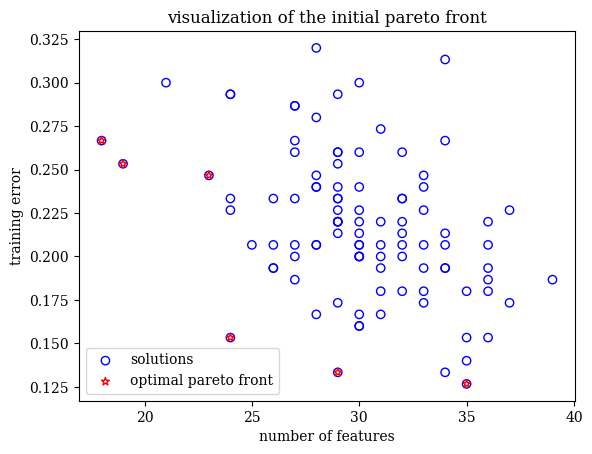

the final pareto front is plotted as: 


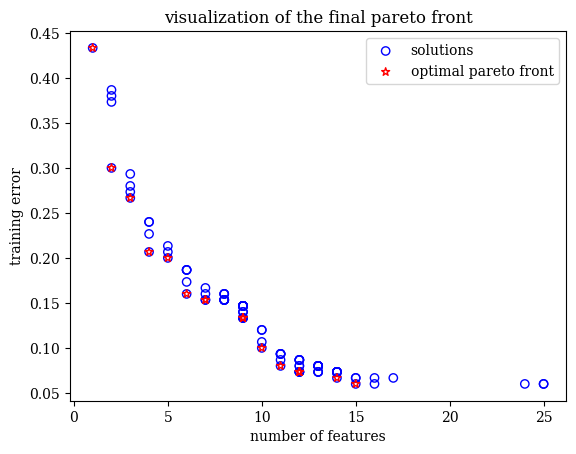

In [146]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

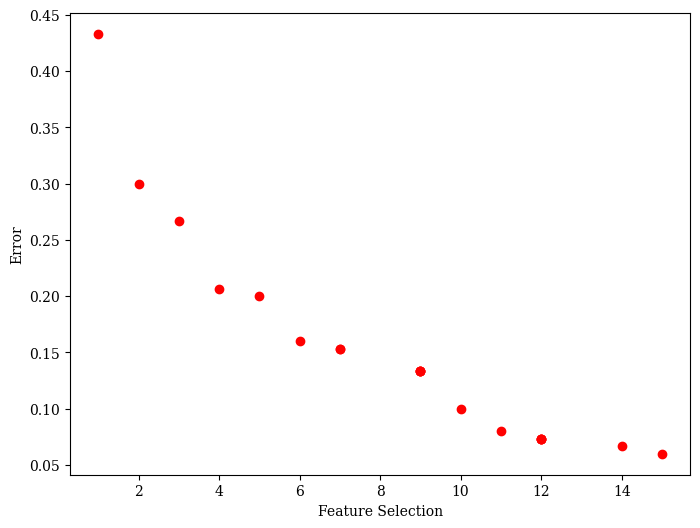

In [156]:
plt.figure(figsize=(8, 6))
plt.scatter(res.F[:, 0], res.F[:, 1], color="red")
plt.xlabel("Feature Selection")
plt.ylabel("Error")
plt.show()

In [148]:
# Optional: Print the Pareto optimal solutions
print("Pareto optimal solutions:")
print(res.F)

Pareto optimal solutions:
[[ 3.          0.26666667]
 [ 9.          0.13333333]
 [ 7.          0.15333333]
 [ 1.          0.43333333]
 [ 2.          0.3       ]
 [12.          0.07333333]
 [ 5.          0.2       ]
 [10.          0.1       ]
 [ 9.          0.13333333]
 [12.          0.07333333]
 [11.          0.08      ]
 [15.          0.06      ]
 [ 6.          0.16      ]
 [ 7.          0.15333333]
 [ 9.          0.13333333]
 [14.          0.06666667]
 [12.          0.07333333]
 [ 9.          0.13333333]
 [ 4.          0.20666667]
 [12.          0.07333333]]


In [150]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f = scaler.fit_transform(f)
hv = ind(f)
print("HV of the best pareto front:" + str(round(hv, 2)))

HV of the best pareto front:0.7
